# Assignment 2 

Github repo: https://github.com/c-wejendorp/ComSocSciAssignment2Group1

Contribution: 

Exercise 1,3,4,5: Christoffer 50% Jason 50%. 

Exercise: 2 William 100%


In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from networkx.readwrite import json_graph
import json
import scipy 
import netwulf as nw
from netwulf import visualize
import random
from scipy.stats import sem, t
import matplotlib.pyplot as plt

# Exercise 1) Mixing Patterns and Assortativity.
Let's dig in and try to understand more about the network of Computational Social Scientists using more advanced features. If your network has more than one component, just work on the giant connected component (GCC) in the exercises below. For the exercises below, you shall use the network you built in Week 4.

> The following cell loads the data and displays the total number of nodes in the graph after the giant connected component (GCC) has been extracted. Note we use our own author/paper data set from assignment 1

In [2]:
f = open('data/graph.json')
data = json.load(f)
G = nx.node_link_graph(data) 
print(f"The number of nodes before the GCC has been found: {len(list(G.nodes))}")
largest_cc = max(nx.connected_components(G), key=len)
# update graph to only include the larget connected component. 
G = G.subgraph(largest_cc)
print(f"The number of nodes after the GCC has been found: {len(list(G.nodes))}")


The number of nodes before the GCC has been found: 2162
The number of nodes after the GCC has been found: 1271


- For each node, compute the fraction of edges that connect to a node that works in the same top field. Find the average value across all nodes:

> In the cell below a function is defined that does exactly that.
When executed on our graph we get the value printed below:

In [12]:
# loop over all nodes and for each node save the number of edges leading to a node with the same top field.
def fracOfNbrsSameTopic(graph):
    for node in list(graph.nodes):
        nodeTopField=graph.nodes[node]['field']
        counter = 0
        for nbr in graph.adj[node]:
            nbrTopField=graph.nodes[nbr]['field']
            if nodeTopField == nbrTopField:
                counter += 1        
        fracOfNbrsSameTopic=counter/len(graph.adj[node])    
        graph.nodes[node]['fracOfNbrsSameTopic'] = fracOfNbrsSameTopic
        
    _,values = zip(*list(graph.nodes.data('fracOfNbrsSameTopic')))
    return sum(values) / len(list(graph.nodes))
    

print(f"Average fraction of shared field edges:  {np.round(fracOfNbrsSameTopic(G), 2)}")


Average fraction of shared field edges:  0.38


- Create a new graph, with the same nodes and edges, but where the association between nodes and field is shuffled. Compute the measure above for this randomized graph.


> The cell below defines a function that takes a graph as input and extracts all the nodes' "field" attributes and reassigns them randomly. 
If we do this we get the value printed below:     



In [13]:
def shuffleNodeFields(graph):
    shuffledGraph=graph.copy()    
    key, values = zip(*list(shuffledGraph.nodes.data('field')))    
    values = list(values)    
    random.shuffle(values)    
    newDict = dict(zip(key,values))
    nx.set_node_attributes(shuffledGraph, newDict, name="field")

    return shuffledGraph

print(f"Average fraction of shared field edges of randomized graph:  {np.round(fracOfNbrsSameTopic(shuffleNodeFields(G)), 2)}")


Average fraction of shared field edges of randomized graph:  0.26


- Repeat the point above 100 times (at least). Plot the distribution of the values obtained and compare it with the value you have found for the real graph. Is the chance to connect to a member of the same field significantly higher than it would be by chance?  

> To solve this question we used bootstrapping and sampled 100 times. We then calculated the empirical confidence interval and concluded;
Based on a significance level of 0.05 the chance of connecting to a member of the same field is significantly higher than it would be by chance. 

> The confidence interval for "the fraction of edges that connect to a node that works in the same top field", if the assocations in the graphs are random, are shown below. We have also plotted the distribution for the sampled values with a proper bin-size


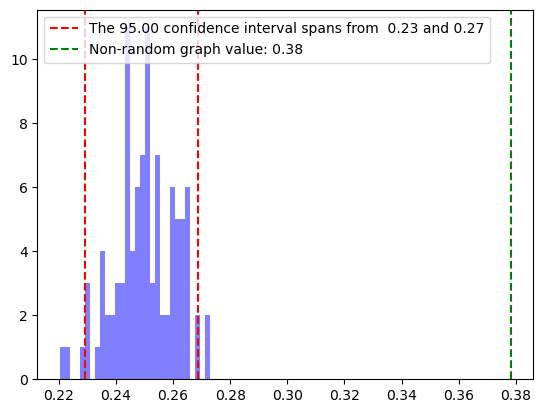

In [5]:
n = 100
avgValues = [fracOfNbrsSameTopic(shuffleNodeFields(G)) for i in range(n)]
#compute the emperical confidence interval
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(avgValues, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(avgValues, p))
num_bins = 30
n, bins, patches = plt.hist(avgValues, num_bins, facecolor='blue', alpha=0.5)
#plot the confidence interval
plt.axvline(x=lower, color='r', linestyle='--',label='The %.2f confidence interval spans from  %.2f and %.2f' % (alpha*100, lower, upper))
plt.axvline(x=upper, color='r', linestyle='--')
plt.axvline(x=fracOfNbrsSameTopic(G), color='g', linestyle='--',label=f"Non-random graph value: {fracOfNbrsSameTopic(G):.2f}")
plt.legend()
plt.show()

- Compute the assortativity coefficient with respect to author's field. How do you interpret the value you obtain? Important: here I do not want you to use the NetworkX implementation, but rather to implement your own version of the measure.


> We found r = 0.14. Our interpretation of this is the following; As the value of r is greater than 0, the graph is somewhat assortative with respect to the attribute "field". This means ths authors' whose top fields are the same tend to work together on papers.   



In [10]:
#we have the following field attributes in our graph
nodefield = nx.get_node_attributes(G, "field")
fields=list(set([nodefield[node] for node in G.nodes]))
print(f"The author fields in our graph are: {fields}")

# Initialize the mixing matrix
n = len(fields)
mixing_matrix = np.zeros((n, n))

# Compute the fraction of edges between nodes with different attributes
for edge in G.edges():
    i = fields.index(nodefield[edge[0]])
    j = fields.index(nodefield[edge[1]])
    mixing_matrix[i][j] += 1

total_edges = G.number_of_edges()
mixing_matrix = mixing_matrix / total_edges

numerator = np.sum(np.diag(mixing_matrix)) - np.sum(row_sums*col_sums)
denominator= 1 - np.sum(row_sums*col_sums)

assortativity =numerator/denominator
# print our calculation of the assortativity coefficient is
print(f"The assortativity coefficient calculated is: {assortativity}") 



The author fields in our graph are: ['Medicine', 'Engineering', 'Computer Science', 'Physics', 'Biology', 'Art', 'Agricultural And Food Sciences', 'Chemistry', 'Political Science', 'History', 'Mathematics', 'Psychology', 'Geology', 'Linguistics', 'Education', 'Business', 'Economics', 'Environmental Science', 'Sociology', 'Materials Science', 'Philosophy', 'Law']


NameError: name 'row_sums' is not defined

- Is the graph assortative with respect to the degree? (e.g. do high-degree scientists tend to link to other high-degree scientists, and low-degree scientists to other low-degree scientists?). Provide an interpretation of your answer.

> Here we have used the NetworkX implementation and found the assortativity coefficient with respect to degree to be -0.079. As this value is smaller than 0, it indicates that there could be disassortative mixing. This means that nodes with different degree values tend to be connected to each other. One example of how this would occur is if teachers / researchers at universities write papers with their students, then the teacher node has a high degree and the stundent node has a low degree. 

In [11]:
q=nx.degree_assortativity_coefficient(G)
print(f"The assortativity coefficient with respect to degree is: {np.round(q, 2)}")

The assortativity coefficient with respect to degree is: -0.08
